In [2]:
!pip install -q requests beautifulsoup4 Flask~=3.0.3 cloudscraper~=1.2.71 pandas~=2.2.2 beautifulsoup4~=4.12.3 pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 8.2 MB/s eta 0:00:00


In [3]:
import cloudscraper
from bs4 import BeautifulSoup
import pandas as pd

class ForexFactoryScraper:
    def __init__(self, impact_filter=False, currency_filter=False):
        url = f'https://www.forexfactory.com/calendar'
        self.df = self.scrape_table(url)
        if impact_filter or currency_filter:
            self.filtered_df = self.filter_dataframe(impact_filter, currency_filter)
        else:
            self.filtered_df = self.df
    def getPageHTML(self,url):
        scraper = cloudscraper.create_scraper()
        page = scraper.get(url).text
        return page

    def filter_dataframe(self, impact_filter, currency_filter):
        filtered_df = self.df[self.df['Impact'].isin(impact_filter) & self.df['Currency'].isin(currency_filter)]
        return filtered_df

    def scrape_table(self,url, currency_filter=''):
        pageHTML = self.getPageHTML(url)
        soup = BeautifulSoup(pageHTML, 'html.parser')
        table = soup.find('table', class_ = 'calendar__table')
        currencies = table.find_all('td', class_='calendar__cell calendar__currency')
        events = table.find_all('span', class_ = 'calendar__event-title')
        impacts = table.find_all('td', class_="calendar__cell calendar__impact")
        times = table.find_all('td', class_="calendar__cell calendar__time")
        dates = table.find_all('span', class_ = 'date')
        date_splits =str(table).split('<span class="date">')
        del date_splits[0]

        currencies_list, events_list, impacts_list, times_list, dates_list = [],[],[],[],[]
        for i in range(len(impacts)):
            if 'yel' in str(impacts[i]):
                impacts_list.append('Low')
            elif 'red' in str(impacts[i]):
                impacts_list.append('High')
            elif 'ora' in str(impacts[i]):
                impacts_list.append('Mid')
            elif 'gra' in str(impacts[i]):
                impacts_list.append('None')
            currencies_list.append(currencies[i].text.strip())
            events_list.append(events[i].text.strip())
            times_list.append(times[i].text.strip())
        reset, dates_list = 0 , []
        for i in range(len(events)):
            if events_list[i] in date_splits[reset]:
                dates_list.append(dates[reset].text.strip())
            else:
                reset+=1
        print(len(dates_list))
        if len(dates_list) < len(events_list):
            for i in range(len(events_list)-len(dates_list)):
                dates_list.append(dates[reset].text.strip())
        df = pd.DataFrame({ 'Date': dates_list, 'Time': times_list, 'Impact': impacts_list,'Currency': currencies_list, 'Event': events_list})
        return df

# table = ForexFactoryScraper()
# table.filtered_df


In [15]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
import matplotlib.dates as mdates
import copy
from datetime import datetime, timedelta

class CorrelationChartingTool:
    def __init__(self, ticker):
        self.ticker = ticker.upper()
        correlations = self.get_correlation_tickers(self.ticker)
        self.correlation_tickers, self.correlation_percentages = [ticker for ticker,percentage in correlations], [percentage for ticker,percentage in correlations]
        correlated_dataframes_price = [self.get_data(ticker) for ticker in self.correlation_tickers]
        self.correlated_dataframes = [self.convert_price_to_percentage(df) for df in correlated_dataframes_price]
        ticker_df = self.get_data(ticker)
        self.ticker_df = self.convert_price_to_percentage(ticker_df)
        self.plot_correlation_chart(self.ticker_df, self.correlated_dataframes)


    def get_data(self, ticker="eurusd", period=3, interval="1h", provider='yfinance'): #optimized
          forex_pairs = ["EURUSD", "USDJPY", "GBPUSD", "USDCHF", "AUDUSD", "USDCAD", "NZDUSD","EURGBP","CHFUSD", "EURJPY", "GBPJPY", "AUDJPY", "NZDJPY", "AUDNZD", "EURAUD","GBPAUD","EURCHF", "EURCAD", "GBPCAD", "EURNZD", "GBPNZD", "CHFJPY", "CADJPY","AUDCAD", "NZDCAD", "AUDCHF", "NZDCHF", "CADCHF","USDSEK", "USDNOK", "USDDKK", "USDZAR", "USDTRY", "USDMXN", "USDSGD","USDHKD", "USDKRW", "USDTHB", "USDCNH", "USDPLN", "USDHUF", "USDCZK","EURSEK", "EURNOK", "EURDKK", "EURTRY", "EURZAR", "EURSGD", "EURHUF","EURPLN", "EURCZK", "GBPSEK", "GBPNOK", "GBPDKK", "GBPTRY", "GBPZAR","AUDSGD", "AUDHKD", "AUDPLN", "CADSGD", "NZDSGD", "SGDJPY", "NOKJPY","SEKJPY", "ZARJPY", "TRYJPY", "MXNJPY"]
          ticker_type = 'stock'
          if ticker.upper() in forex_pairs:
            ticker_type='forex'
          if provider.lower() == 'yfinance':
              import yfinance as yf
              if ticker_type.lower() == 'forex':
                ticker = yf.Ticker(f"{ticker.upper()}=X")
              else:
                ticker = yf.Ticker(ticker.upper())
              #df = ticker.history(period="max", interval=interval)
              df = ticker.history(period="1y", interval=interval)
              df.rename(columns={'Close': 'close', 'Open': 'open', 'Low':'low', 'High': 'high'}, inplace=True)
              #df.drop(columns=['Volume', 'Dividends', 'Stock Splits'],axis='columns', inplace=True)
              df = df.iloc[:-1] #dropping last row cuz yfinance shows a candle even tho its not finished

          return df

    def convert_price_to_percentage(self,df):  #optimized
        converted_df = df.pct_change() * 100
        converted_df = converted_df.fillna(0)
        return converted_df

    def get_correlation_tickers(self, ticker):
        ticker = ticker[:3].upper()  # Normalize the input ticker
        correlations = {
        'USD': [('EURUSD', -95), ('USDJPY', 89), ('GC=F', -80), ('DX-Y.NYB', 92), ('CL=F', -82)],
        'EUR': [('EURUSD', 95), ('EURGBP', 88), ('EURAUD', 80), ('GC=F', -78), ('EURJPY', 87)],
        'GBP': [('EURGBP', 88), ('GBPUSD', 87), ('GBPJPY', 84), ('CL=F', 83), ('^FTSE', 82)],
        'AUD': [('EURAUD', 80), ('AUDUSD', 83), ('AUDJPY', 79), ('GC=F', 77), ('^AXJO', 81)],
        'CAD': [('USDCAD', 90), ('CADJPY', 85), ('CADCHF', 82), ('CL=F', 88), ('^GSPC', 80)],
        'CHF': [('USDCHF', 85), ('CHFJPY', 78), ('EURCHF', 81), ('GC=F', -79), ('SMI', 80)],
        'JPY': [('USDJPY', 89), ('EURJPY', 87), ('GBPJPY', 86), ('^N225', 84), ('GC=F', -80)],
        'NZD': [('NZDUSD', 84), ('AUDNZD', 83), ('NZDJPY', 82), ('DairyPrices', 85), ('GC=F', 80)]}
        if ticker in correlations:
            return correlations[ticker]
        else:
            return f"No correlation data available for ticker: {ticker}"


    def plot_correlation_chart(self, ticker_df, correlation_dfs=list):
        color_list = ['blue', 'red', 'green', 'purple', 'orange', 'pink','blue', 'red', 'green', 'purple', 'orange', 'pink','blue', 'red', 'green', 'purple', 'orange', 'pink','blue', 'red', 'green', 'purple', 'orange', 'pink','blue', 'red', 'green', 'purple', 'orange', 'pink']
        num_rows = len(correlation_dfs[0])
        quarter_index = int(num_rows * 0.995)
        plt.style.use('dark_background')
        fig, ax = plt.subplots(figsize=(9, 6))
        zoom = -30
        for i, df in enumerate(correlation_dfs):
            try:
                if len(df)==0:
                    continue
                df = df.iloc[zoom:]
                df.index = pd.to_datetime(df.index)
                df['close'].plot(ax=ax, linestyle='-', color=color_list[i], label=f'{self.correlation_tickers[i]} (Correlation: {self.correlation_percentages[i]}%)')
            except Exception as e:
                print(e)
        ticker_df = ticker_df.iloc[zoom:]
        ticker_df.index = pd.to_datetime(ticker_df.index)
        ticker_df['close'].plot(ax=ax, linestyle='-', color='white', label=f'{self.ticker} Chart')


        ax.set_title(f"Correlation charts with {self.ticker}", fontsize=16, color='white')
        ax.set_xlabel('Timestamp', fontsize=14, color='white')
        ax.set_ylabel('Price', fontsize=14, color='white')
        ax.tick_params(axis='both', which='major', labelsize=12, colors='white')
        #ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plt.xticks(rotation=45)
        ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=12, frameon=False)
        ax.grid(True, color='#555555', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()
# tool = CorrelationChartingTool(ticker='usdchf')


96


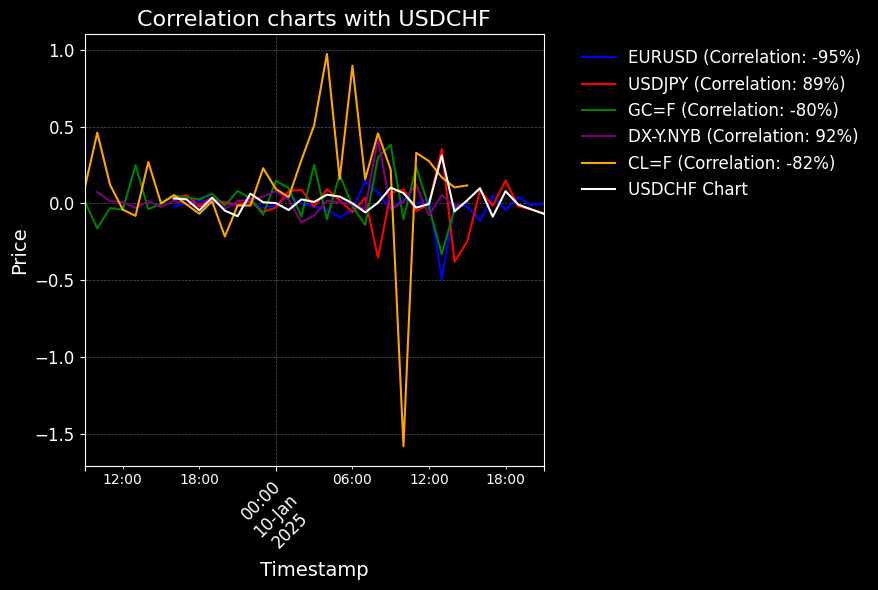

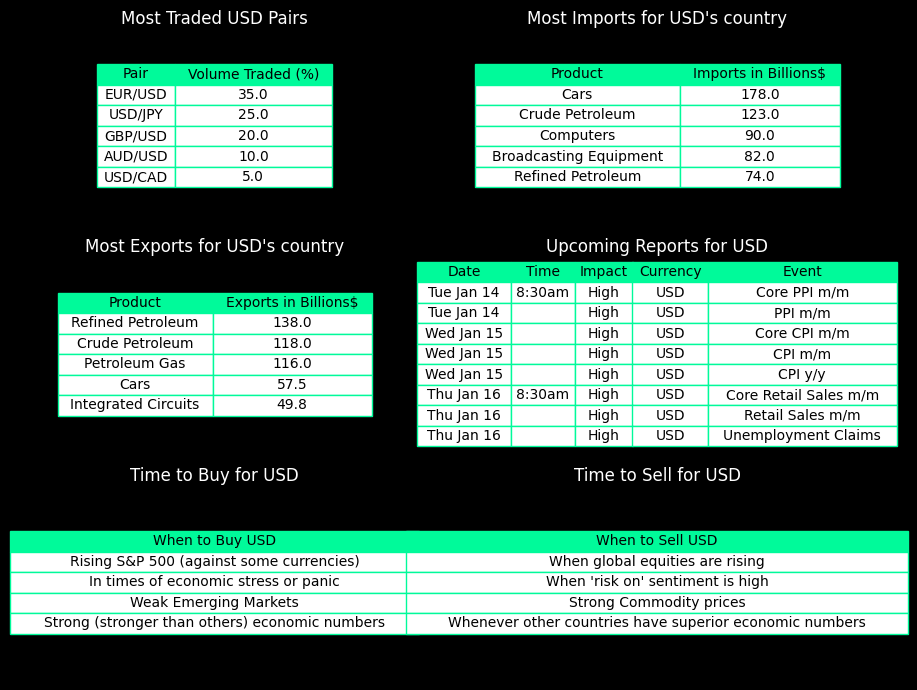

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class Currency_Geopolitical_Scene_Analyzer:
    def __init__(self, currency):
        self.currency, currency = currency.upper(), currency.upper()
        most_traded_pair_df = self.show_most_traded_pairs(self.currency)
        imports_df, exports_df = self.show_imports_exports(self.currency)
        news_df = self.show_upcoming_reports([self.currency], ['High'])
        self.show_correlation_charts(self.currency)
        time_to_buy_df, time_to_sell_df = self.show_when_to_buysell(self.currency)
        #self.plot_four_dataframes(most_traded_pair_df, imports_df, news_df, time_to_buysell_df)
        dfs = {f'Most Traded {currency} Pairs': most_traded_pair_df, f"Most Imports for {currency}'s country": imports_df, f"Most Exports for {currency}'s country": exports_df, f"Upcoming Reports for {currency}": news_df, f"Time to Buy for {currency}": pd.DataFrame(time_to_buy_df),f"Time to Sell for {currency}": pd.DataFrame(time_to_sell_df)}
        self.plot_multiple_dataframe_tables(list(dfs.values()), list(dfs.keys()))

    def show_most_traded_pairs(self, currency):
        fx_pairs = {"AUD": {"AUD/USD": 30.0,"AUD/JPY": 20.0,"AUD/CAD": 15.0,"AUD/NZD": 10.0,"EUR/AUD": 8.0},"NZD": {"NZD/USD": 35.0,"NZD/JPY": 20.0,"AUD/NZD": 15.0,"EUR/NZD": 12.0,"NZD/CAD": 8.0},"CAD": {"USD/CAD": 40.0,"CAD/JPY": 25.0,"EUR/CAD": 15.0,"AUD/CAD": 10.0,"GBP/CAD": 5.0},"CHF": {"EUR/CHF": 35.0,"USD/CHF": 30.0,"CHF/JPY": 15.0,"GBP/CHF": 10.0,"AUD/CHF": 5.0},"JPY": {"USD/JPY": 40.0,"EUR/JPY": 25.0,"GBP/JPY": 15.0,"AUD/JPY": 10.0,"NZD/JPY": 5.0},"USD": {"EUR/USD": 35.0,"USD/JPY": 25.0,"GBP/USD": 20.0,"AUD/USD": 10.0,"USD/CAD": 5.0},"EUR": {"EUR/USD": 40.0,"EUR/JPY": 20.0,"EUR/GBP": 15.0,"EUR/AUD": 10.0,"EUR/CHF": 5.0},"GBP": {"GBP/USD": 30.0,"EUR/GBP": 25.0,"GBP/JPY": 20.0,"GBP/AUD": 15.0,"GBP/CAD": 5.0}}
        traded_pairs_df = pd.DataFrame(fx_pairs[currency].items(), columns=['Pair', 'Volume Traded (%)'])
        return traded_pairs_df

    def show_imports_exports(self, currency):
        imports_exports_data = {"AUD": {"Exports": {"Iron Ore": 77.2,"Coal": 55.1,"Natural Gas": 39.8,"Gold": 18.9,"Aluminum Ore": 5.5},"Imports": {"Refined Petroleum": 15.6,"Cars": 14.2,"Crude Petroleum": 7.6,"Computers": 7.2,"Broadcasting Equipment": 6.5}},"NZD": {"Exports": {"Concentrated Milk": 5.6,"Butter": 2.5,"Cheese": 2.3,"Frozen Bovine Meat": 2.1,"Rough Wood": 1.7},"Imports": {"Cars": 3.5,"Refined Petroleum": 2.8,"Crude Petroleum": 1.9,"Delivery Trucks": 1.2,"Broadcasting Equipment": 1.1}},"CAD": {"Exports": {"Crude Petroleum": 98.0,"Cars": 42.0,"Gold": 14.0,"Refined Petroleum": 12.0,"Vehicle Parts": 10.0},"Imports": {"Cars": 28.0,"Vehicle Parts": 20.0,"Refined Petroleum": 15.0,"Computers": 8.0,"Delivery Trucks": 7.0}},"CHF": {"Exports": {"Gold": 63.8,"Packaged Medicaments": 47.2,"Vaccines, Blood, Antisera": 32.1,"Base Metal Watches": 20.2,"Jewelry": 12.5},"Imports": {"Gold": 55.4,"Packaged Medicaments": 20.3,"Vaccines, Blood, Antisera": 15.7,"Jewelry": 10.1,"Cars": 7.8}},"JPY": {"Exports": {"Cars": 104.0,"Integrated Circuits": 33.0,"Vehicle Parts": 28.0,"Industrial Printers": 12.0,"Passenger and Cargo Ships": 11.0},"Imports": {"Crude Petroleum": 64.0,"Petroleum Gas": 50.0,"Coal": 25.0,"Integrated Circuits": 20.0,"Broadcasting Equipment": 15.0}},"USD": {"Exports": {"Refined Petroleum": 138.0,"Crude Petroleum": 118.0,"Petroleum Gas": 116.0,"Cars": 57.5,"Integrated Circuits": 49.8},"Imports": {"Cars": 178.0,"Crude Petroleum": 123.0,"Computers": 90.0,"Broadcasting Equipment": 82.0,"Refined Petroleum": 74.0}},"EUR": {"Exports": {"Cars": 400.0,"Packaged Medicaments": 150.0,"Aircraft": 100.0,"Vehicle Parts": 90.0,"Refined Petroleum": 80.0},"Imports": {"Crude Petroleum": 300.0,"Cars": 200.0,"Refined Petroleum": 150.0,"Natural Gas": 120.0,"Computers": 100.0}},"GBP": {"Exports": {"Cars": 45.0,"Packaged Medicaments": 30.0,"Crude Petroleum": 25.0,"Refined Petroleum": 20.0,"Gold": 18.0},"Imports": {"Cars": 60.0,"Gold": 50.0,"Crude Petroleum": 40.0,"Refined Petroleum": 35.0,"Packaged Medicaments": 30.0}}}
        # imports_data_df = pd.DataFrame.from_dict(imports_exports_data[currency]['Imports'], orient='index', columns=['Imports in Billions$'])
        # exports_data_df = pd.DataFrame.from_dict(imports_exports_data[currency]['Exports'], orient='index', columns=['Exports in Billions$'])
        imports_data_df = pd.DataFrame(imports_exports_data[currency]['Imports'].items(), columns=['Product', 'Imports in Billions$'])
        exports_data_df = pd.DataFrame(imports_exports_data[currency]['Exports'].items(), columns=['Product', 'Exports in Billions$'])
        return imports_data_df, exports_data_df

    def show_upcoming_reports(self, currency, impacts):
        fx_fctry_scraper = ForexFactoryScraper(impact_filter=impacts, currency_filter=currency)
        return fx_fctry_scraper.filtered_df

    def show_correlation_charts(self, currency):
        if currency!='USD':
            correlation_tool = CorrelationChartingTool(ticker=f"{currency}USD")
        elif currency=='USD':
            correlation_tool = CorrelationChartingTool(ticker=f"{currency}CHF")

    def show_when_to_buysell(self, currency):
        trading_conditions = {
        "CHF": {
            "Time to Buy": [
                "Falling S&P 500 - Against Risk-on currencies (NZD, AUD, CAD)",
                "Rising Gold Prices and Demand",
                "World disaster, pandemic, political unrest, etc",
                "When EUR is weak (only against EUR)"
            ],
            "Time to Sell": [
                "Rising S&P 500 - Against risk on currencies (AUD, NZD, CAD)",
                "Falling Gold Prices and Demand",
                "When currency swap differentials are high",
                "When EUR is weak (against other currencies)"
            ]
        },
        "EUR": {
            "Time to Buy": [
                "Rising S&P 500 (against some safety currencies)",
                "When the USD is out of favor",
                "Strong (stronger than others) economic numbers"
            ],
            "Time to Sell": [
                "When global equities are falling (against safety currencies)",
                "When USD is in favor",
                "Whenever other countries have superior economic numbers"
            ]
        },
        "GBP": {
            "Time to Buy": [
                "Rising S&P 500 (against risk off currencies - USD, JPY, CHF)",
                "During election periods",
                "Increased volatility in metals trading",
                "Strong (stronger than others) economic numbers"
            ],
            "Time to Sell": [
                "Falling S&P 500 (against risk off currencies - USD, JPY, CHF)",
                "During election periods",
                "Lower volatility in metals trading",
                "Whenever other countries have superior economic numbers"
            ]
        },
        "JPY": {
            "Time to Buy": [
                "Falling S&P 500 - This is when we see the biggest trends",
                "During credit crisis",
                "World disaster, pandemic, political unrest, etc",
                "Basically, anytime there is fear"
            ],
            "Time to Sell": [
                "Rising S&P 500 (against risk on currencies - AUD, NZD, CAD)",
                "When interest rate differentials are high (aka 'the carry trade')",
                "Investor and trader complacency",
                "In good times (aka bubbles)"
            ]
        },
        "CAD": {
            "Time to Buy": [
                "Rising Crude Oil",
                "With rising USD and rising equity markets",
                "Strong Emerging Markets",
                "Strong (stronger than others) economic numbers"
            ],
            "Time to Sell": [
                "When Crude Oil is in decline",
                "When global equities are weak",
                "Weak Commodity prices",
                "Whenever other countries have superior economic numbers"
            ]
        },
        "NZD": {
            "Time to Buy": [
                "Rising S&P 500 - Against Risk-off currencies (USD, JPY, CHF)",
                "Rising Iron Ore & Gold Prices and Demand",
                "Strong Chinese economic growth",
                "When the AUD & Australian growth are significantly less than New Zealand"
            ],
            "Time to Sell": [
                "Falling S&P 500 - Against risk off currencies (USD, JPY, CHF)",
                "Falling Iron Ore & Gold Prices and Demand",
                "During any times of global economic or geo-political stress",
                "When the AUD & Australian growth are significantly higher than New Zealand"
            ]
        },
        "AUD": {
            "Time to Buy": [
                "Rising S&P 500 - Against Risk-off currencies (USD, JPY, CHF)",
                "Rising Iron Ore & Gold Prices and Demand",
                "Strong Chinese economic growth",
                "When the RBA's interest rates are higher than other Central Banks"
            ],
            "Time to Sell": [
                "Falling S&P 500 - Against risk off currencies (USD, JPY, CHF)",
                "Falling Iron Ore & Gold Prices and Demand",
                "When Chinese Economic growth is slowing or expected to slow",
                "During any times of global economic or geo-political stress"
            ]
        },
        "USD": {
            "Time to Buy": [
                "Rising S&P 500 (against some currencies)",
                "In times of economic stress or panic",
                "Weak Emerging Markets",
                "Strong (stronger than others) economic numbers"
            ],
            "Time to Sell": [
                "When global equities are rising",
                "When 'risk on' sentiment is high",
                "Strong Commodity prices",
                "Whenever other countries have superior economic numbers"
            ]}}
        #df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in trading_conditions[currency].items()]))
        buy_df, sell_df = pd.DataFrame(trading_conditions[currency]['Time to Buy'], columns=[f'When to Buy {currency}']), pd.DataFrame(trading_conditions[currency]['Time to Sell'], columns=[f'When to Sell {currency}'])
        return buy_df, sell_df
        #return df
        #self.df2=df

    def plot_multiple_dataframe_tables(self, dfs, titles=None):
        num_tables = len(dfs)
        if titles is None:
            titles = [f"Table {i+1}" for i in range(num_tables)]

        # Calculate grid size (2 rows, 3 columns to fit 5 tables neatly, leaving 1 empty if necessary)
        rows, cols = 3, 2
        fig, axes = plt.subplots(rows, cols, figsize=(9, 7))
        axes = axes.flatten()


        for i, (df, ax) in enumerate(zip(dfs, axes)):
            # Configure the axis for dark mode
            ax.axis("tight")
            ax.axis("off")
            ax.set_facecolor("#333333")  # Dark gray background for each subplot

            # Create the table with light text on dark background
            table = ax.table(
                cellText=df.values,
                colLabels=df.columns,
                cellLoc="center",
                loc="center",
                colColours=["#90EE90"] * len(df.columns),  # Header background color
            )
            table.auto_set_font_size(True)
            #table.set_fontsize(10)
            table.auto_set_column_width(col=list(range(len(df.columns))))

            # Style the table cells
            for key, cell in table.get_celld().items():
                cell.set_edgecolor("#00FA9A")  # Cell border color
                cell.set_text_props(color="black")  # White text
                if key[0] == 0:  # Header row
                    cell.set_facecolor("#00FA9A")  # Slightly brighter header

            # Add title with improved styling
            ax.set_title(
                titles[i],
                fontsize=12,
                color="#ffffff",
                pad=3
            )

        # Hide any extra subplots if there are fewer than rows * cols
        for j in range(num_tables, len(axes)):
            axes[j].axis("off")

        # Adjust layout and display
        plt.tight_layout()
        plt.show()
GPINDICATOR = Currency_Geopolitical_Scene_Analyzer("usd")
